## Further analysis
We are going to do some more further statistical analysis on the data to see if we can find any patterns in the data to see whether there are certain types of individuals that are more likely to spend more time on social media to the detriment of their health or their studies. 
We need to import the following libraries to plot these visuals:

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import f_oneway

The first plot will be a correlation heatmap. This allows us to see whether there are any positive or negative correlation between the values within the dataset and will go a long way to answering whether our hypothesis are true or false.
Relationships range from 1.00 to -1.00.
The closer to 1.00 the relationship is means that there is positive correlation meaning as the first value goes up so does the second. Whereas the closer to -1.00 you get you'll be looking at negative correlation, as one value increases that will cause the second value to decrease. The closer to 0.00 means there is no causation and any pattern could be random.

Once the dataset is loaded in, we have assigned all object dtypes to a variable ready for conversion into numerical form for further analysis. We will iterate over each column in my_objects and assign them with a numerical value. For example gender values Male and Female will become 1 and 0 respectively. 

In [10]:
# Load the dataset
df = pd.read_csv('../data/cleaned_data/student_social_media_addiction_cleaned.csv')

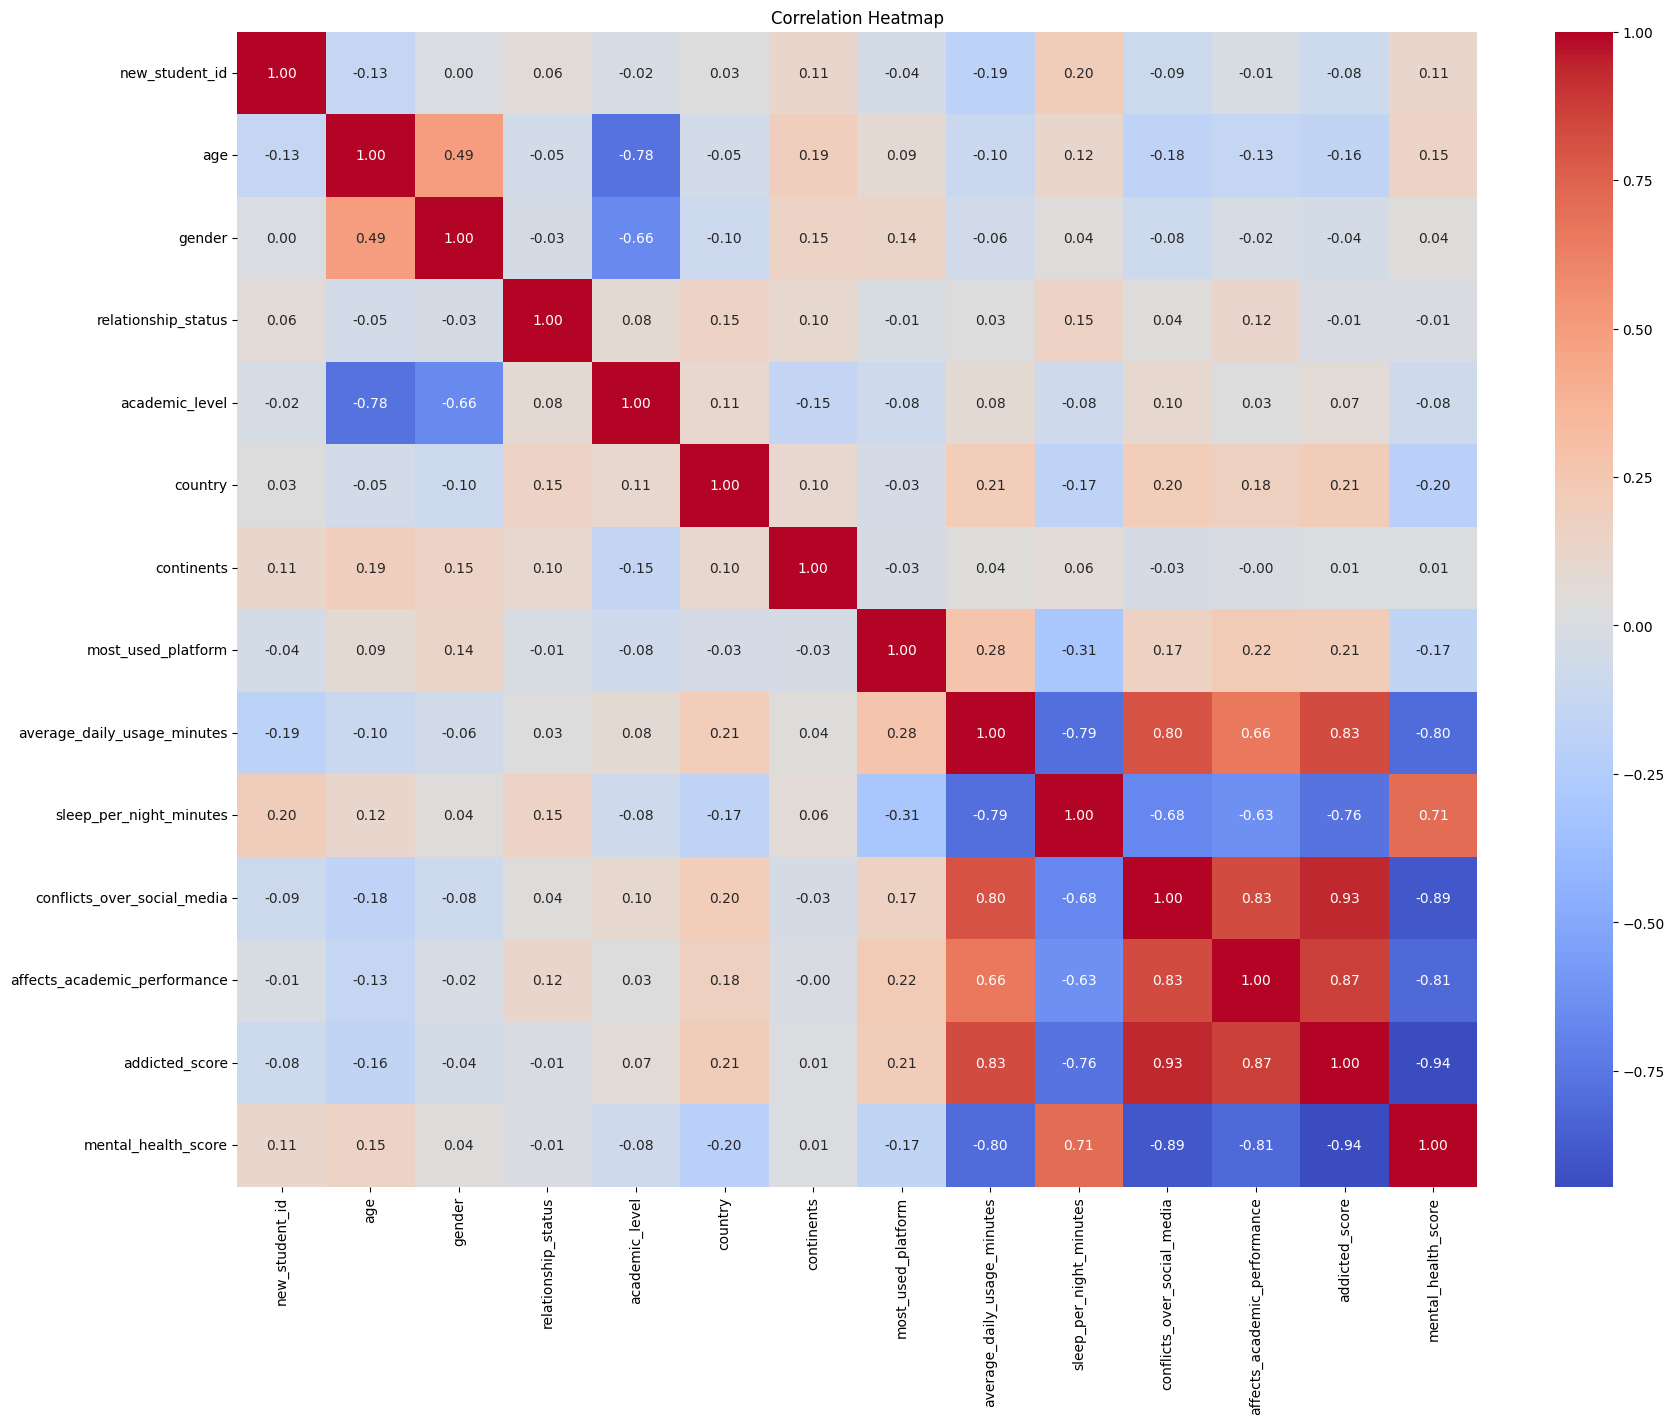

In [ ]:
# Convert categoricals to number values, drop the categorical values already represented in minutes
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

cols_to_exclude = ['average_daily_use_by_hour', 'sleep_hours_per_night']

corr = df.drop(columns=cols_to_exclude).corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [20]:
# Document strong correlations ( > 0.75 or < -0.75 )
cols_to_exclude = ['average_daily_use_by_hour', 'sleep_hours_per_night']

df_corr = df.drop(columns=cols_to_exclude)

corr = df_corr.corr(numeric_only=True)

threshold = 0.75

strong_corrs = (
    corr.stack()
        .reset_index()
        .rename(columns={'level_0':'var1', 'level_1':'var2', 0:'corr'})
)

# Remove self-correlations
strong_corrs = strong_corrs[strong_corrs['var1'] != strong_corrs['var2']]

# Keep only > 0.75 or < -0.75
strong_corrs = strong_corrs[(strong_corrs['corr'] > threshold) | (strong_corrs['corr'] < -threshold)]

# Remove duplicate pairs (A,B) and (B,A)
strong_corrs['pair'] = strong_corrs.apply(lambda x: tuple(sorted([x['var1'], x['var2']])), axis=1)
strong_corrs = strong_corrs.drop_duplicates(subset='pair').drop(columns='pair')
strong_corrs = strong_corrs.sort_values(by='corr', ascending=False)

strong_corrs


,var1,var2,corr
152,conflicts_over_social_media,addicted_score,0.932669
166,affects_academic_performance,addicted_score,0.867147
151,conflicts_over_social_media,affects_academic_performance,0.832498
124,average_daily_usage_minutes,addicted_score,0.829678
122,average_daily_usage_minutes,conflicts_over_social_media,0.803468
138,sleep_per_night_minutes,addicted_score,-0.764002
18,age,academic_level,-0.776261
121,average_daily_usage_minutes,sleep_per_night_minutes,-0.786871
125,average_daily_usage_minutes,mental_health_score,-0.800719
167,affects_academic_performance,mental_health_score,-0.808502


In [21]:
# Document medium correlations ( 0.5 > x <= 0.74 or -0.5 < x >= -0.74 )
cols_to_exclude = ['average_daily_use_by_hour', 'sleep_hours_per_night']  # example

df_corr = df.drop(columns=cols_to_exclude)

corr = df_corr.corr(numeric_only=True)

lower = 0.50
upper = 0.749

moderate_corrs = (
    corr.stack()
        .reset_index()
        .rename(columns={'level_0':'var1', 'level_1':'var2', 0:'corr'})
)

# Remove self-correlations
moderate_corrs = moderate_corrs[moderate_corrs['var1'] != moderate_corrs['var2']]

# Keep only correlations within the moderate range
moderate_corrs = moderate_corrs[
    ((moderate_corrs['corr'] >= lower) & (moderate_corrs['corr'] <= upper)) |
    ((moderate_corrs['corr'] <= -lower) & (moderate_corrs['corr'] >= -upper))
]

# Remove duplicate (A,B) / (B,A)
moderate_corrs['pair'] = moderate_corrs.apply(lambda x: tuple(sorted([x['var1'], x['var2']])), axis=1)
moderate_corrs = moderate_corrs.drop_duplicates(subset='pair').drop(columns='pair')

# Sort by strongest first
moderate_corrs = moderate_corrs.sort_values(by='corr', ascending=False)

moderate_corrs


,var1,var2,corr
139,sleep_per_night_minutes,mental_health_score,0.707560
123,average_daily_usage_minutes,affects_academic_performance,0.662701
137,sleep_per_night_minutes,affects_academic_performance,-0.625949
32,gender,academic_level,-0.658585
136,sleep_per_night_minutes,conflicts_over_social_media,-0.676934
